In [354]:
import pandas as pd
from experiment_measurement.rosbag2df import read_rosbag_all_in_one, Rosbag2Df
from experiment_measurement.data_aggregation import aggregate_tables
import rclpy 
### change the following line according to what config you want to use
from experiment_measurement.config.lidar_data import table_column_config

In [357]:
# read data from sqlite db
data = read_rosbag_all_in_one('rosbag/rosbag_4_.db3')

In [425]:
# create pandas dataframe from raw data
tables = aggregate_tables(data['rosbag'], table_column_config, 10**9)

{'robot_2':               timestamp  amcl_pose_x  amcl_pose_y  amcl_pose_theta  tf_pose_x  \
0   1685440959446524826          NaN          NaN              NaN        NaN   
1   1685440960446524826          NaN          NaN              NaN        NaN   
2   1685440961446524826          NaN          NaN              NaN        NaN   
3   1685440962446524826          NaN          NaN              NaN        NaN   
4   1685440963446524826          NaN          NaN              NaN        NaN   
5   1685440964446524826          NaN          NaN              NaN        NaN   
6   1685440965446524826          NaN          NaN              NaN        NaN   
7   1685440966446524826     0.000000     2.000000         0.000000        NaN   
8   1685440967446524826          NaN          NaN              NaN   0.000006   
9   1685440968446524826          NaN          NaN              NaN   0.000009   
10  1685440969446524826          NaN          NaN              NaN   0.000008   
11  168544097044

In [445]:
# combine data for multiple robots into one dataframe
for robot in tables.keys():
    tables[robot].dropna(subset=['scan', 'poses']).to_csv(path_or_buf='rosbag_'+str(robot)+'.csv', index=False)
#    tables[robot]['robot'] = robot
#df = pd.concat(tables.values(), ignore_index=True)

In [446]:
# read in data of one robot and drop NaN value rows in scan and poses 
df = pd.read_csv('rosbag_robot_2.csv')
#df = df.dropna(subset=['scan','poses']).reset_index()
#df = df.drop(columns=['Unnamed: 0'])

In [447]:
df

,timestamp,amcl_pose_x,amcl_pose_y,amcl_pose_theta,tf_pose_x,tf_pose_y,tf_pose_theta,scan,poses
0,1685440961446524826,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
1,1685440962446524826,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
2,1685440963446524826,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
3,1685440964446524826,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
4,1685440965446524826,NaN,NaN,NaN,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
5,1685440966446524826,0.000000,2.000000,0.000000,NaN,NaN,NaN,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
6,1685440967446524826,NaN,NaN,NaN,0.000006,1.999999,4.548333e-07,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
7,1685440968446524826,NaN,NaN,NaN,0.000009,1.999999,6.875747e-07,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
8,1685440969446524826,NaN,NaN,NaN,0.000008,1.999999,8.996387e-07,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...
9,1685440970446524826,NaN,NaN,NaN,0.000008,1.999998,1.006547e-06,"array('f', [inf, inf, inf, inf, inf, inf, inf,...",communication_interfaces.msg.ModelStatesStampe...


In [419]:
# index for line in data frame 
idx = 0 

# get object names  
names = [el[1:-1] for el in df['poses'][idx].split('[')[1].split(']')[0].split(', ')]

# get object positions 
positions_x = [] 
positions_y = [] 

string = df['poses'][idx]

for i in range(0, len(names)):
    start = string.find('Point')
    stop = string[start:].find(')')
    pose = string[start+6:start+stop].split(', ')
    positions_x.append(float(pose[0][2:]))
    positions_y.append(float(pose[1][2:]))
    string = string[start+6:]

# get lidar data 
ld = [float(el) for el in df['scan'][idx][12:-2].split(',')]

In [420]:
# get object and robot positions from data frame 
import math 
import numpy as np 

objects_x = [] 
objects_y = [] 
robots_x = [] 
robots_y = [] 
lidar_x = []
lidar_y = [] 

# position of current robot (lidar data)
r_x = 0 
r_y = 0 

for i in range(0, len(names)):

    if names[i][:5] == "robot":
        robots_x.append(positions_x[i])
        robots_y.append(positions_y[i])   
        
        if names[i] == df['robot'][idx]:
            r_x = positions_x[i]
            r_y = positions_y[i]
                                                
    elif names[i] != "ground_plane": 
        objects_x.append(positions_x[i])
        objects_y.append(positions_y[i])   

# transform lidar data to x, y positions 

for i in range(0, 360): #:
    if not math.isinf(ld[i]):
        lidar_x.append(ld[i] * math.cos(np.deg2rad(i)) + r_x)
        lidar_y.append(ld[i] * math.sin(np.deg2rad(i)) + r_y)

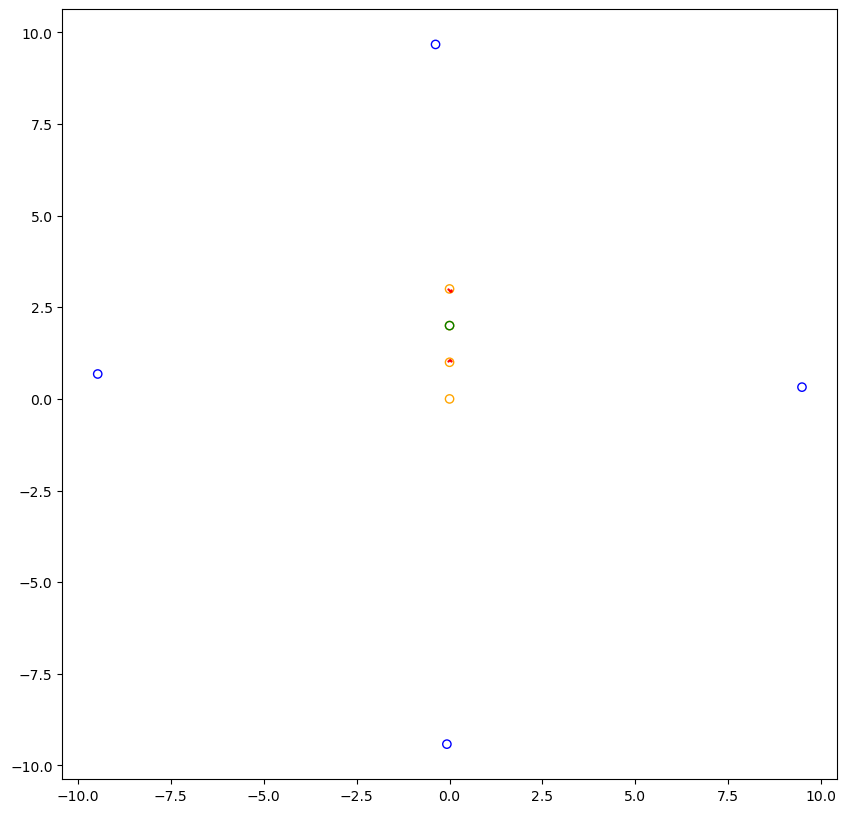

In [421]:
# work with the data (i.e. visualize the path)
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(x=objects_x, y=objects_y, facecolors='none', edgecolors='blue') # objects except ground plane 
plt.scatter(x=robots_x, y=robots_y, facecolors='none', edgecolors='orange') # robots 
plt.scatter(r_x, r_y, facecolors='none', edgecolors='green') # robots 
plt.scatter(lidar_x, lidar_y, s=0.4, color='red') # lidar 